## Feature Examination CVD dataset

In [45]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

### Build the CVD training dataset
I need to load the core spreadsheet, and load the extra spreadsheet where required
Then I need to match the IDs. THen we have a spreadsheet that we can fit a logistic regression model with

In [2]:
CVD_core_df = pd.read_csv("/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/EdData/clinscore_data.csv")

In [3]:
CVD_core_df

,Unnamed: 0.1,Unnamed: 0,ID,sbjGroup,age,sex,diabetes,hypertension,hyperlipidaemia,smoking,...,micrBld,smoking_0,smoking_1,smoking_2,total_fazekas,scale_fazekas,scale_pvs,scale_micrbld,stroke_les,scale_stroke
0,146,146,CVD247,1,68.0,2,0,1,1.0,0.0,...,0.0,1.0,0.0,0.0,2.0,0.0,1.0,NaN,1.0,1.0
1,134,134,CVD219,1,81.0,1,0,0,0.0,0.0,...,0.0,1.0,0.0,0.0,3.0,0.0,1.0,NaN,1.0,0.0
2,131,131,CVD195,1,71.0,1,0,1,0.0,2.0,...,1.0,0.0,0.0,1.0,6.0,1.0,1.0,NaN,1.0,1.0
3,121,121,CVD173,1,68.0,1,0,1,0.0,2.0,...,0.0,0.0,0.0,1.0,4.0,1.0,0.0,NaN,1.0,0.0
4,104,104,CVD128,1,83.0,1,0,0,0.0,1.0,...,0.0,0.0,1.0,0.0,3.0,0.0,0.0,NaN,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,201,201,CVD302,1,55.0,1,0,1,0.0,2.0,...,0.0,0.0,0.0,1.0,2.0,0.0,1.0,NaN,1.0,1.0
246,138,138,CVD230,1,50.0,1,0,0,1.0,2.0,...,0.0,0.0,0.0,1.0,3.0,0.0,1.0,NaN,1.0,1.0
247,107,107,CVD132,1,56.0,1,0,0,0.0,2.0,...,0.0,0.0,0.0,1.0,2.0,0.0,0.0,NaN,1.0,0.0
248,215,215,CVD316,1,78.0,1,0,1,1.0,2.0,...,1.0,0.0,0.0,1.0,2.0,0.0,0.0,NaN,1.0,0.0


### Add the sample diversity data

In [4]:
uncertainty_type = "ssn_ens"

In [5]:
uncertainty_type

'ssn_ens'

In [6]:
# if uncertainty_type != "deterministic":
#     sample_div_dfs = [pd.read_csv(f"/home/s2208943/ipdis/data/preprocessed_data/EdData_output_maps/{uncertainty_type}/cv{i}_sample_div_data.csv") for i in range(6)]
    

sample_div_dfs = [pd.read_csv(f"/home/s2208943/ipdis/data/preprocessed_data/EdData_output_maps/{uncertainty_type}/cv{i}_sample_div_data.csv") for i in range(6)]
    
sample_div_df = pd.concat(sample_div_dfs)
sample_div_df = sample_div_df.drop(columns="Unnamed: 0")
CVD_core_df = CVD_core_df.merge(sample_div_df, on="ID")
CVD_core_df = CVD_core_df.drop(columns="Unnamed: 0.1")
CVD_core_df = CVD_core_df.loc[CVD_core_df['dice'] > 0.005 ] # get rid of the examples where the image was broken when presented to the dataloader and resulted in dice of 0.

In [7]:
# load the deterministic model dice score
deterministic_score_df = [pd.read_csv(f"/home/s2208943/ipdis/data/preprocessed_data/EdData_output_maps/deterministic/cv{i}_sample_div_data.csv") for i in range(6)]
deterministic_score_df = pd.concat(deterministic_score_df)
deterministic_score_df = deterministic_score_df.drop(columns="Unnamed: 0")
deterministic_score_df = deterministic_score_df.rename(columns={"dice":"deterministic_dice", "f1":"deterministic_f1", "avd":"deterministic_avd", "recall":"deterministic_recall"})

CVD_core_df = CVD_core_df.merge(deterministic_score_df, on="ID")
#CVD_core_df = CVD_core_df.drop(columns="Unnamed: 0.1")
CVD_core_df = CVD_core_df.loc[CVD_core_df['deterministic_dice'] > 0.005 ] # g

In [8]:
CVD_core_df.keys()

Index(['Unnamed: 0', 'ID', 'sbjGroup', 'age', 'sex', 'diabetes',
       'hypertension', 'hyperlipidaemia', 'smoking', 'SBP', 'DBP', 'totalChl',
       'MMSE', 'ICV', 'WMH', 'PVWMH', 'DWMH', 'deepAtrophy', 'supAtrophy',
       'BGPVS', 'CSPVS', 'relLes', 'oldLes', 'micrBld', 'smoking_0',
       'smoking_1', 'smoking_2', 'total_fazekas', 'scale_fazekas', 'scale_pvs',
       'scale_micrbld', 'stroke_les', 'scale_stroke', 'dice', 'f1', 'avd',
       'recall', 'sample_div_std', 'sample_div_IQR', 'sample_div_skew',
       'sample_div_vd_std', 'sample_div_vd_IQR', 'sample_div_vd_skew',
       'deterministic_dice', 'deterministic_f1', 'deterministic_avd',
       'deterministic_recall'],
      dtype='object')

In [9]:
def load_model_output_stats(output_type, threshold, fields=None):
    df = pd.read_csv(f"/home/s2208943/ipdis/data/preprocessed_data/umap_data_spreadsheets/EdData/{uncertainty_type}_{output_type}_{threshold}.csv")
    if fields != None:
        return df[fields]
    return df

In [10]:
def merge_datasets(core_df, output_types, thresholds, selected_fields):
    for output_type, thresh, fields in zip(output_types, thresholds, selected_fields):
        
        extra_df = load_model_output_stats(output_type, thresh, fields) # load the specific output type at the given threshold, and select the desired fields
        
        extra_df = extra_df.rename(columns={key: f"{output_type}{thresh}_{key}" if key != 'ID' else 'ID' for key in extra_df.keys()}) # modify the column name so that we know which columns belong to which input type
        
        core_df = core_df.merge(extra_df, on="ID")
    
    core_df = core_df.drop(columns='ID')       
    
    return core_df

In [11]:
save_folder = "CVD_feature_plots/"

In [12]:
sns.set_style("whitegrid")

In [13]:
def get_uniques(df, key):
    values = df[key].values
    uniques = np.unique(values)
    uniques = uniques[np.logical_not(np.isnan(uniques))] # remove nan, if it is there
    return uniques

In [14]:
def simple_hist_bar_plot(ax, df, key, xlabel, color='#1cdaeb'):
    ax.grid(which="major", axis='x', color='#DAD8D7', alpha=0.5, zorder=0)
    ax.grid(which="major", axis='y', color='#DAD8D7', alpha=0.5, zorder=0)
    classes = get_uniques(df, key)
    values = df[key].values
    counts = [0 for _ in range(len(classes))]
    for i, c in enumerate(classes):
        counts[i] = np.sum(values == c)
    ax.bar(classes, counts, zorder=2, color=color); # zorder 2 is above grid but below axis (3 puts it above the axis
    if xlabel == None:
        xlabel = key
    ax.set_xlabel(xlabel)
    ax.set_ylabel("count")
    ax.set_xticks(classes)
    ax.spines[['top','right']].set_visible(False) # Remove the top and right spines
    ax.spines[['left', 'bottom']].set_linewidth(1.1) # make the left and bottom spines thicker#
    ax.spines[['left', 'bottom']].set_color('#585858')

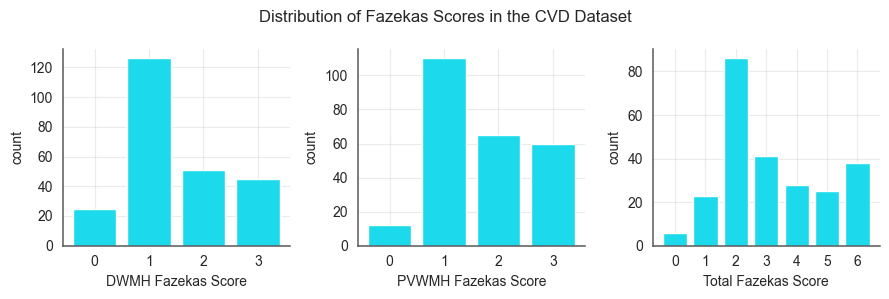

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
simple_hist_bar_plot(axs[0], CVD_core_df, 'DWMH', 'DWMH Fazekas Score')
simple_hist_bar_plot(axs[1], CVD_core_df, 'PVWMH', 'PVWMH Fazekas Score')
simple_hist_bar_plot(axs[2], CVD_core_df, 'total_fazekas', 'Total Fazekas Score')
plt.suptitle("Distribution of Fazekas Scores in the CVD Dataset")
fig.tight_layout()

### Add Umap feature data

In [17]:
all_image_extracted_fields = ['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean',
       'cc_size_std', 'cc_size_skew', 'cc_size_kurt', 'cc_vd_mean',
       'cc_vd_std', 'cc_vd_skew', 'cc_vd_kurt', 'sum', 'mean', 'std', 'skew',
       'kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg',
       'prop_seg_uncertain', 'dist_mean', 'dist_std', 'dist_skew', 'dist_kurt',]

pred_values = ['seg_volume', 'vent_volume']

In [19]:
added_inputs = ["pred", "ent", "ent", "ent", "ent", "ent", "pred", "pred", "pred", "pred", "var"]
thresholds = [0.5, 0.1, 0.3, 0.2, 0.4, 0.45, 0.1, 0.3, 0.5, 0.6, 0.06]
# added_fields = [['cc_num', 'cc_unsegmented_ccs', 'cc_size_mean'], ['kurtosis', 'prop_umap_segmented', 'prop_umap_within_expanded_seg'], ['kurtosis']]
added_fields = [pred_values, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields, all_image_extracted_fields]
added_fields = [f+['ID'] for f in added_fields]

included_terms = [0, 1,2,3,4,5,6, 7, 8, 9]#0]#, 2]#, 1]#, 3]
added_inputs = [added_inputs[idx] for idx in included_terms]
thresholds = [thresholds[idx] for idx in included_terms]
added_fields = [added_fields[idx] for idx in included_terms]

core_fields = CVD_core_df.keys()

In [37]:
combined_df = merge_datasets(CVD_core_df[core_fields], added_inputs, thresholds, added_fields)
combined_df = combined_df.dropna(subset=['total_fazekas', 'DWMH', 'PVWMH'])
combined_df['total_fazekas'] = combined_df['total_fazekas'].astype('int32')
combined_df['DWMH'] = combined_df['DWMH'].astype('int32')
combined_df['PVWMH'] = combined_df['PVWMH'].astype('int32')

### make the plots

### How does predicted WMH volume predict fazekas score?

In [38]:
def get_palette(x):
    if x == "DWMH":
        palette = sns.color_palette("YlOrBr", 4)
    elif x == "PVWMH":
        palette = sns.color_palette("YlGn", 4)
    else:
        palette = sns.color_palette("Purples", 7)
        
    return palette

In [39]:
def simple_box_plot(ax, df, x, y, xlabel=None, ylabel=None, logy=False, logx=False, ylim=None, no_y_axis=False, title=None):
    
    palette = get_palette(x)
    
    ax = sns.boxplot(data=df, x=x, y=y, ax=ax, hue=x, legend=None, palette=dict([(v, palette[int(v)]) for v in df[x].unique()]))
    if xlabel == None:
        xlabel = x
    if ylabel == None:
        ylabel = y
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.spines[['top','right']].set_visible(False) # Remove the top and right spines
    ax.spines[['left', 'bottom']].set_linewidth(1.1) # make the left and bottom spines thicker#
    #ax.spines[['left', 'bottom']].set_color('#585858')
    
    if no_y_axis:
        ax.tick_params(left=False, labelleft=False)
        ax.spines[['left']].set_visible(False)
    
    # give a thicker spine.
    for spine in ax.spines.values():
        spine.set_linewidth(2)  # Adjust thickness as desired
    
    if logy:
        ax.set_yscale('log')
    if logx:
        ax.set_xscale('log')
        
    if ylim:
        ax.set_ylim(ylim)
    
    if title:
        ax.set_title(title)

In [40]:
import matplotlib.patheffects as PathEffects
def simple_scatter_plot(ax, df, x, y, hue=None, xlabel=None, ylabel=None, logy=False, logx=False, legend_title=None, no_y_axis=True):
    palette = get_palette(hue)
    ax = sns.scatterplot(ax=ax, data=df, x=x, y=y, hue=hue, palette=dict([(v, palette[int(v)]) for v in df[hue].unique()]))
    if xlabel == None:
        xlabel = x
    if ylabel == None:
        ylabel = y
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.spines[['top','right']].set_visible(False) # Remove the top and right spines
    ax.spines[['left', 'bottom']].set_linewidth(2) # make the left and bottom spines thicker#
    # ax.spines[['left', 'bottom']].set_color('#585858')
    if logy:
        ax.set_yscale('log')
    if logx:
        ax.set_xscale('log')
    print(get_uniques(df, hue))
    plt.legend(loc='lower right', title=legend_title)
    
    if no_y_axis:
        ax.tick_params(left=False, labelleft=False)
        ax.spines[['left']].set_visible(False)
    
    ### adding the pearson correlation coefficient to the plot
    xs = df[x]
    ys = df[y]
    if logx:
        xs = np.log(xs.values)
    if logy:
        ys = np.log(ys.values)
    
    r = scipy.stats.pearsonr(df[x], df[y])[0]
    if r < 0.48:
        xalign = 0.95
        halign="right"
    else:
        xalign=0.05
        halign="left"
    
    # Add text in top right corner
    txt = ax.text(xalign, 0.95, fr'$r={r:.2f}$', 
            verticalalignment='top', 
            horizontalalignment=halign,
            transform=ax.transAxes,
            fontsize=12) 
    txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='w')])

In [41]:
combined_df

,Unnamed: 0,sbjGroup,age,sex,diabetes,hypertension,hyperlipidaemia,smoking,SBP,DBP,...,pred0.6_std,pred0.6_skew,pred0.6_kurtosis,pred0.6_prop_umap_segmented,pred0.6_prop_umap_within_expanded_seg,pred0.6_prop_seg_uncertain,pred0.6_dist_mean,pred0.6_dist_std,pred0.6_dist_skew,pred0.6_dist_kurt
0,146,1,68.0,2,0,1,1.0,0.0,129.0,78.0,...,0.124334,-0.709981,2.107922,1.0,1.0,0.881306,2.857038,3.231192,1.647564,4.590954
1,134,1,81.0,1,0,0,0.0,0.0,NaN,NaN,...,0.118501,-0.855402,2.437789,1.0,1.0,0.887452,1.529583,2.153632,3.678891,17.104274
2,131,1,71.0,1,0,1,0.0,2.0,125.0,90.0,...,0.095158,-1.946972,5.832467,1.0,1.0,0.955142,3.026242,2.105849,1.392608,5.169240
3,121,1,68.0,1,0,1,0.0,2.0,140.0,90.0,...,0.096639,-1.875996,5.514272,1.0,1.0,0.949530,2.834982,2.483670,1.942177,7.250811
4,104,1,83.0,1,0,0,0.0,1.0,174.0,94.0,...,0.121605,-0.755384,2.234231,1.0,1.0,0.866854,2.602430,2.908750,2.248525,7.306261
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,201,1,55.0,1,0,1,0.0,2.0,150.0,90.0,...,0.120138,-0.109217,1.709168,1.0,1.0,0.751174,2.470634,4.621222,2.233766,6.062059
244,138,1,50.0,1,0,0,1.0,2.0,155.0,110.0,...,0.124958,-0.527656,1.887094,1.0,1.0,0.846563,1.347131,2.264483,4.642393,27.257916
245,107,1,56.0,1,0,0,0.0,2.0,130.0,80.0,...,0.119964,-0.287404,1.757369,1.0,1.0,0.843862,1.817400,3.293627,3.112733,11.335499
246,215,1,78.0,1,0,1,1.0,2.0,171.0,79.0,...,0.122823,-0.767849,2.231525,1.0,1.0,0.876376,1.227555,1.901791,4.404069,24.869114


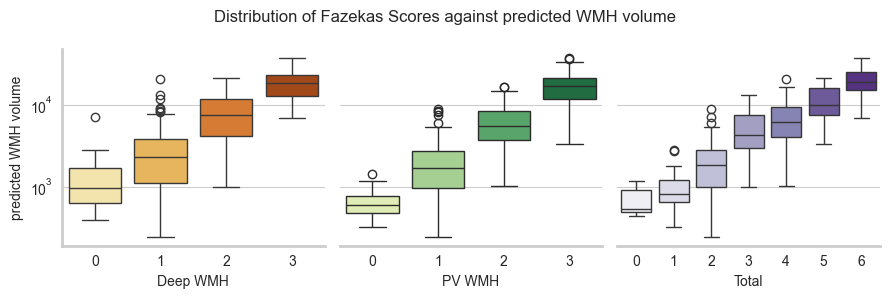

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
simple_box_plot(axs[0], combined_df, x='DWMH', y='pred0.5_seg_volume', xlabel="Deep WMH", ylabel="predicted WMH volume", logy=True)
simple_box_plot(axs[1], combined_df, x='PVWMH', y='pred0.5_seg_volume', xlabel="PV WMH", ylabel="", logy=True, no_y_axis=True)
simple_box_plot(axs[2], combined_df, x='total_fazekas', y='pred0.5_seg_volume', xlabel='Total', ylabel="", logy=True, no_y_axis=True)
plt.suptitle("Distribution of Fazekas Scores against predicted WMH volume")
plt.savefig(save_folder+"predicted volme vs fazekas.pdf", bbox_inches="tight")
fig.tight_layout()

### examine how each feature distributes with volume and fazekas category (PVWMH, DWMH, Total, then GT predicted WMH volume)
dice, lesion f1, avd, sample_div_std, sample_div_IQR, sample_div_skew, and vd equivalents

In [43]:
def quad_fazekas_comparison_plot_box(df, y, ylabel, kind='box', logy=False, log_scatter_y=True, scatter_hue="DWMH"):
    fig, axs = plt.subplots(1, 4, figsize=(12, 3))
    simple_box_plot(axs[0], df, x='DWMH', y=y, xlabel="Deep WMH", ylabel=ylabel, logy=logy)
    simple_box_plot(axs[1], df, x='PVWMH', y=y, xlabel="PV WMH", ylabel="", logy=logy, no_y_axis=True)
    simple_box_plot(axs[2], df, x='total_fazekas', y=y, xlabel='Total', ylabel="", logy=logy, no_y_axis=True)
    simple_scatter_plot(axs[3], df, x='pred0.5_seg_volume', y=y, hue=scatter_hue, xlabel="predicted WMH volume", ylabel="", logy=logy, logx=log_scatter_y, legend_title="DWMH" if "d" in scatter_hue.lower() else "PVWMH", no_y_axis=True)
    if ylabel == None:
        ylabel = y
    plt.suptitle(f"Comparing ({ylabel}) with Fazekas")
    fig.tight_layout()
    plt.savefig(save_folder+f"{uncertainty_type}_{y}_featureplot.pdf", bbox_inches="tight")
    
    

[0 1 2 3]


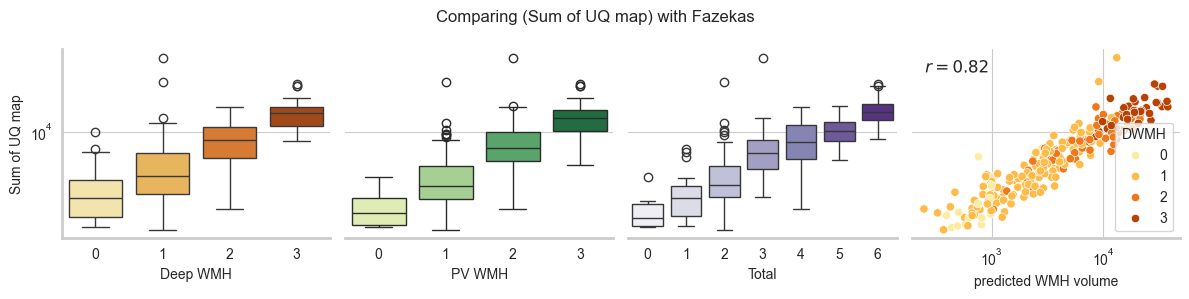

In [48]:
quad_fazekas_comparison_plot_box(combined_df, y=f'ent0.1_sum', ylabel="Sum of UQ map", logy=True)

[0 1 2 3]


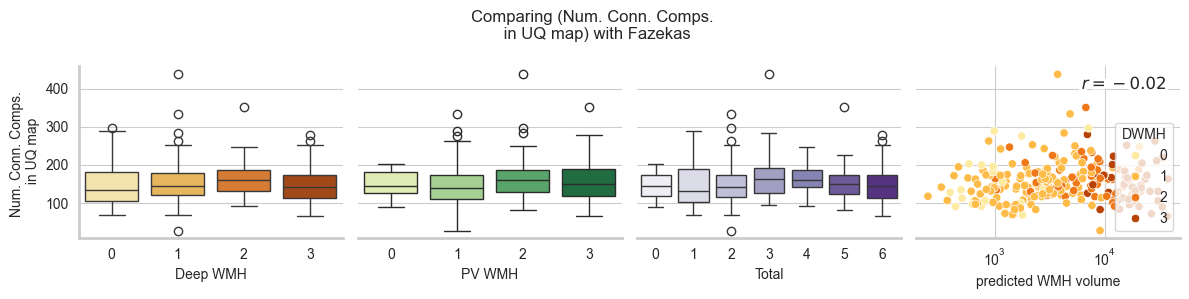

In [53]:
quad_fazekas_comparison_plot_box(combined_df, y=f'ent0.2_cc_num', ylabel="Num. Conn. Comps. \n in UQ map")

[0 1 2 3]


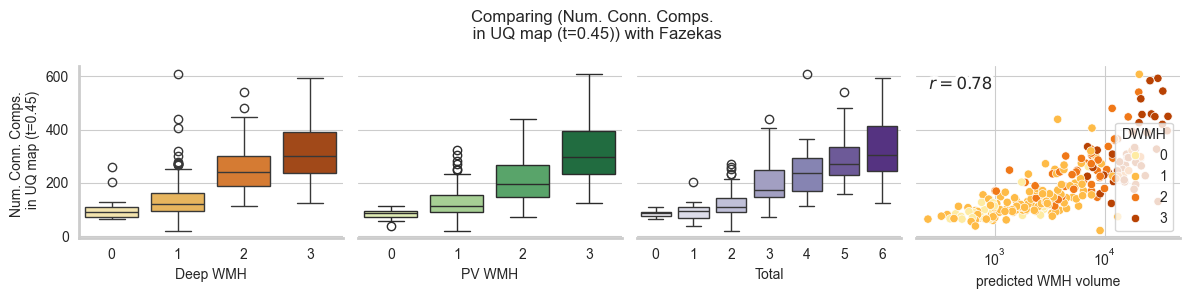

In [54]:
quad_fazekas_comparison_plot_box(combined_df, y=f'ent0.45_cc_num', ylabel="Num. Conn. Comps. \n in UQ map (t=0.45)")

[0 1 2 3]


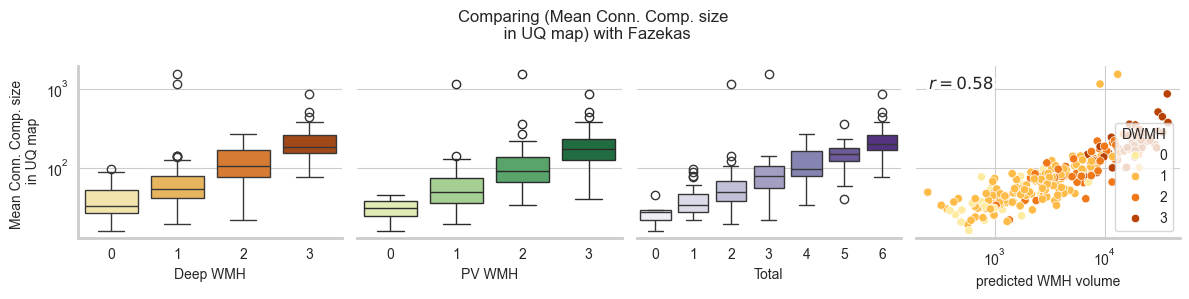

In [56]:
quad_fazekas_comparison_plot_box(combined_df, y=f'ent0.1_cc_size_mean', ylabel="Mean Conn. Comp. size \n in UQ map", logy=True)

[0 1 2 3]


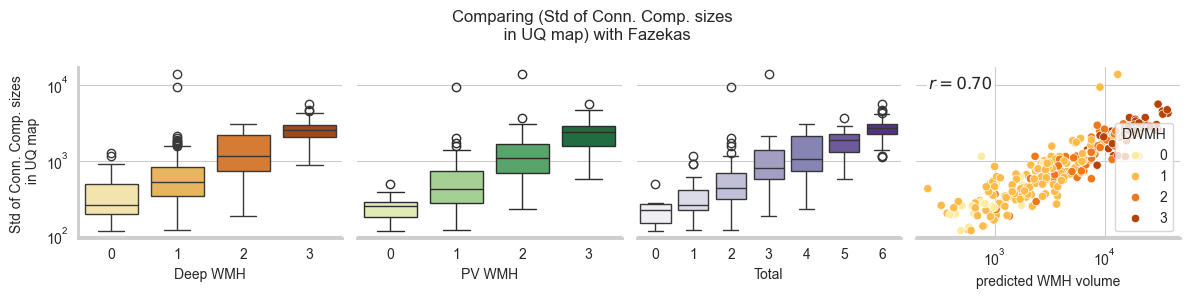

In [57]:
quad_fazekas_comparison_plot_box(combined_df, logy=True, y=f'ent0.1_cc_size_std', ylabel="Std of Conn. Comp. sizes \n in UQ map")

[0 1 2 3]


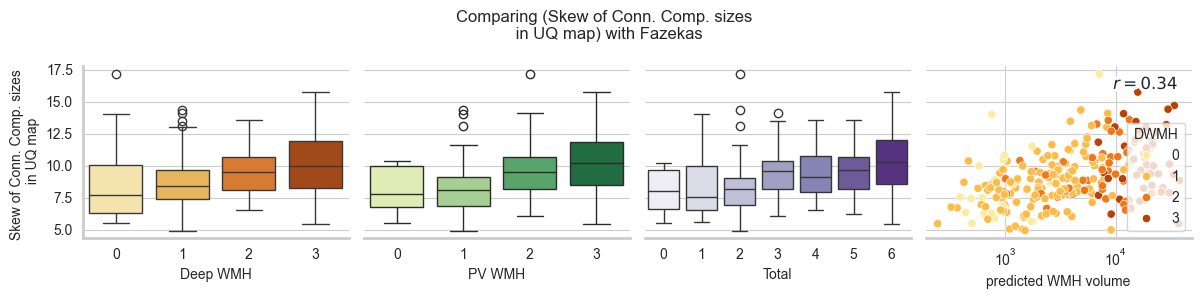

In [62]:
quad_fazekas_comparison_plot_box(combined_df, y=f'ent0.2_cc_size_skew', ylabel="Skew of Conn. Comp. sizes \n in UQ map")

[0 1 2 3]


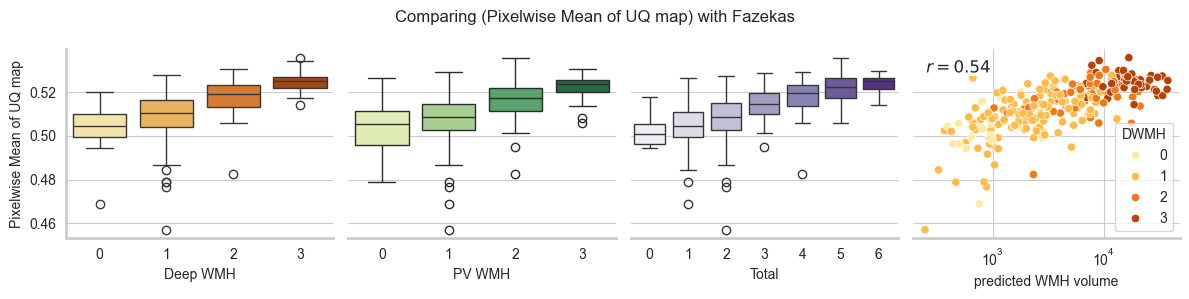

In [63]:
quad_fazekas_comparison_plot_box(combined_df, y=f'ent0.3_mean', ylabel="Pixelwise Mean of UQ map")

[0 1 2 3]


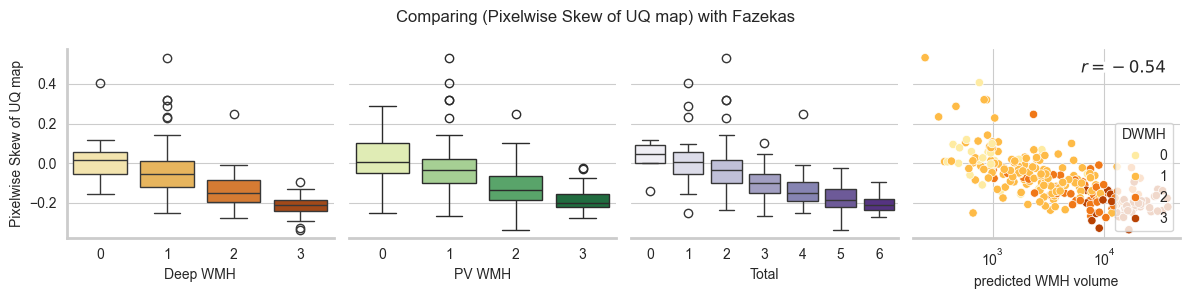

In [64]:
quad_fazekas_comparison_plot_box(combined_df, y=f'ent0.3_skew', ylabel="Pixelwise Skew of UQ map")

[0 1 2 3]


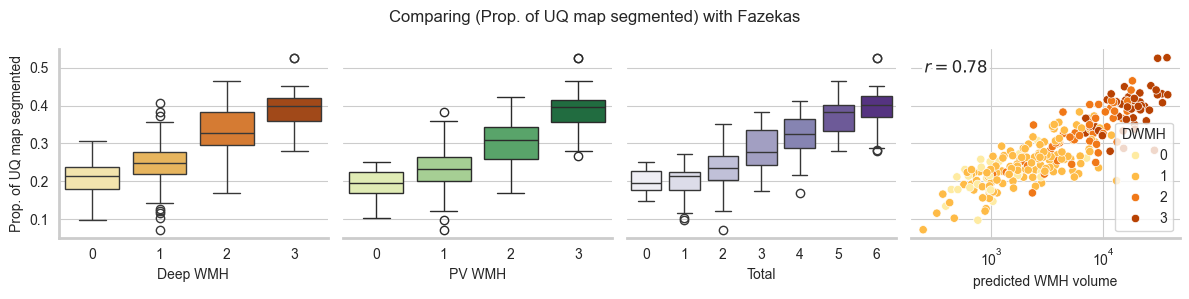

In [65]:
quad_fazekas_comparison_plot_box(combined_df, y=f'ent0.3_prop_umap_segmented', ylabel="Prop. of UQ map segmented")

[0 1 2 3]


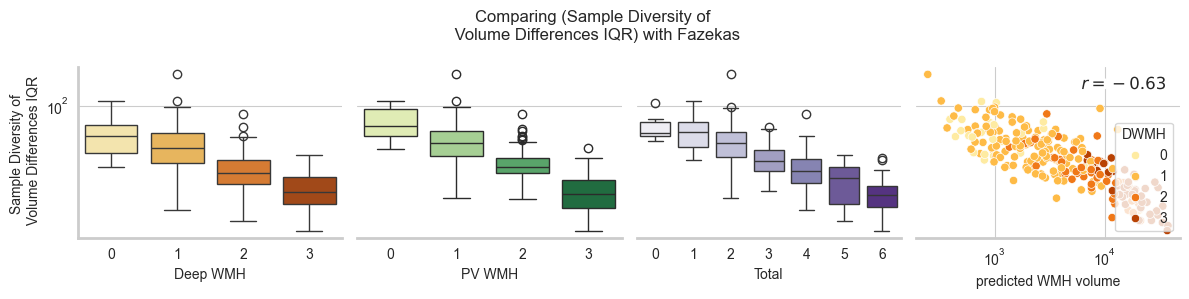

In [66]:
quad_fazekas_comparison_plot_box(combined_df, y='sample_div_vd_IQR', ylabel='Sample Diversity of \n Volume Differences IQR', kind='box', logy=True)

[0 1 2 3]


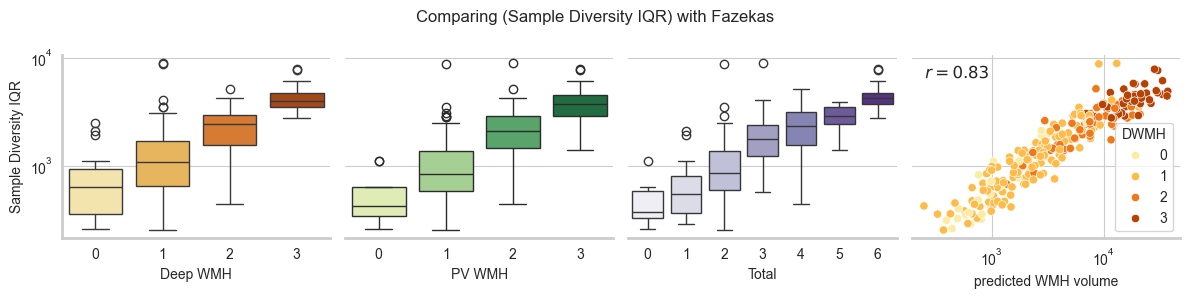

In [67]:
quad_fazekas_comparison_plot_box(combined_df, y='sample_div_IQR', ylabel='Sample Diversity IQR', kind='box', logy=True)

### comparing with fixed dwmh, pvwmh

In [68]:
def compare_d_vs_pv_fixed_plots(df, y, ylabel=None, logy=False, log_scatter_y=True):
    fig, axs = plt.subplots(2, 4, figsize=(8, 6))
    ylim = (df[y].min(), df[y].max())
    simple_box_plot(axs[0,0], df.loc[df['PVWMH'] == 0], x='DWMH', y=y, xlabel="Deep WMH", ylabel=ylabel, logy=logy, ylim=ylim, title="PV WMH = 0")
    simple_box_plot(axs[0,1], df.loc[df['PVWMH'] == 1], x='DWMH', y=y, xlabel="Deep WMH", ylabel="", logy=logy, ylim=ylim, no_y_axis=True, title="PV WMH = 1")
    simple_box_plot(axs[0,2], df.loc[df['PVWMH'] == 2], x='DWMH', y=y, xlabel='Deep WMH', ylabel="", logy=logy, ylim=ylim, no_y_axis=True, title="PV WMH = 2")
    simple_box_plot(axs[0,3], df.loc[df['PVWMH'] == 3], x='DWMH', y=y, xlabel='Deep WMH', ylabel="", logy=logy, ylim=ylim, no_y_axis=True, title="PV WMH = 3")
    simple_box_plot(axs[1,0], df.loc[df['DWMH'] == 0], x='PVWMH', y=y, xlabel="PV WMH", ylabel=ylabel, logy=logy, ylim=ylim, title="Deep WMH = 0")
    simple_box_plot(axs[1,1], df.loc[df['DWMH'] == 1], x='PVWMH', y=y, xlabel="PV WMH", ylabel="", logy=logy, ylim=ylim, no_y_axis=True, title="Deep WMH = 1")
    simple_box_plot(axs[1,2], df.loc[df['DWMH'] == 2], x='PVWMH', y=y, xlabel='PV WMH', ylabel="", logy=logy, ylim=ylim, no_y_axis=True, title="Deep WMH = 2")
    simple_box_plot(axs[1,3], df.loc[df['DWMH'] == 3], x='PVWMH', y=y, xlabel='PV WMH', ylabel="", logy=logy, ylim=ylim, no_y_axis=True, title="Deep WMH = 3")
    plt.suptitle(f"Comparing ({ylabel}) with fixed Fazekas categories")
    fig.tight_layout()
    
    if not ylabel:
        ylabel = y
    
    plt.savefig(save_folder+f"{uncertainty_type}_{ylabel}_compared_fixed_featureplot.pdf", bbox_inches="tight")
    

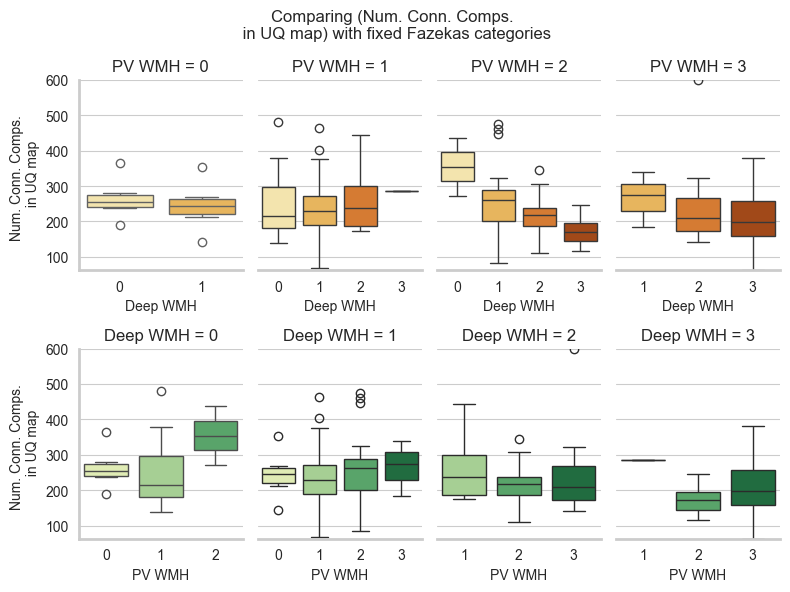

In [71]:
compare_d_vs_pv_fixed_plots(combined_df, y=f'ent0.1_cc_num', ylabel="Num. Conn. Comps. \n in UQ map", log_scatter_y=True)

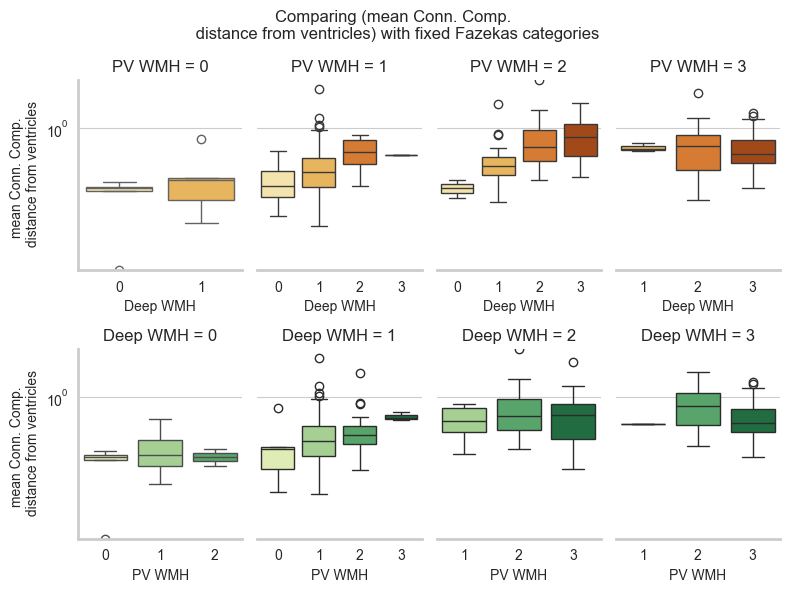

In [76]:
compare_d_vs_pv_fixed_plots(combined_df, y=f'ent0.1_cc_vd_mean', ylabel="mean Conn. Comp. \n distance from ventricles", log_scatter_y=True, logy=True)

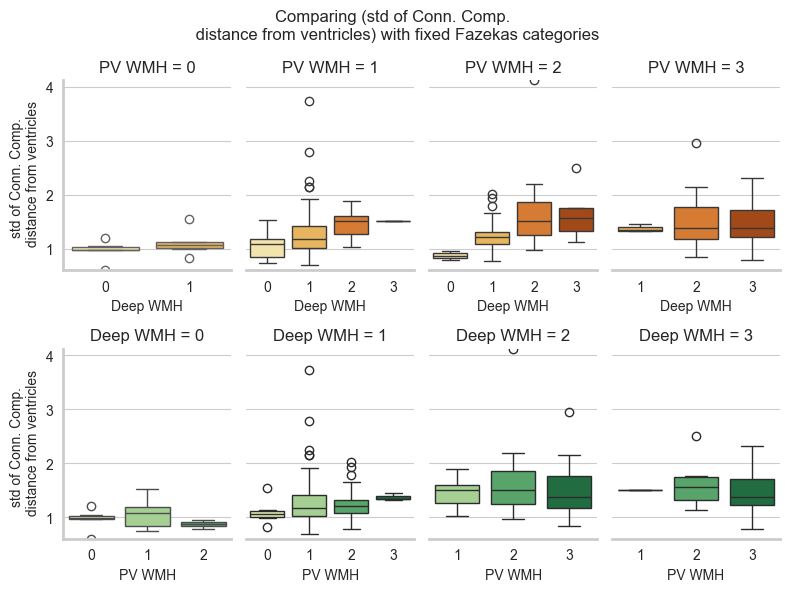

In [77]:
compare_d_vs_pv_fixed_plots(combined_df, y=f'ent0.1_cc_vd_std', ylabel="std of Conn. Comp. \n distance from ventricles", log_scatter_y=True)

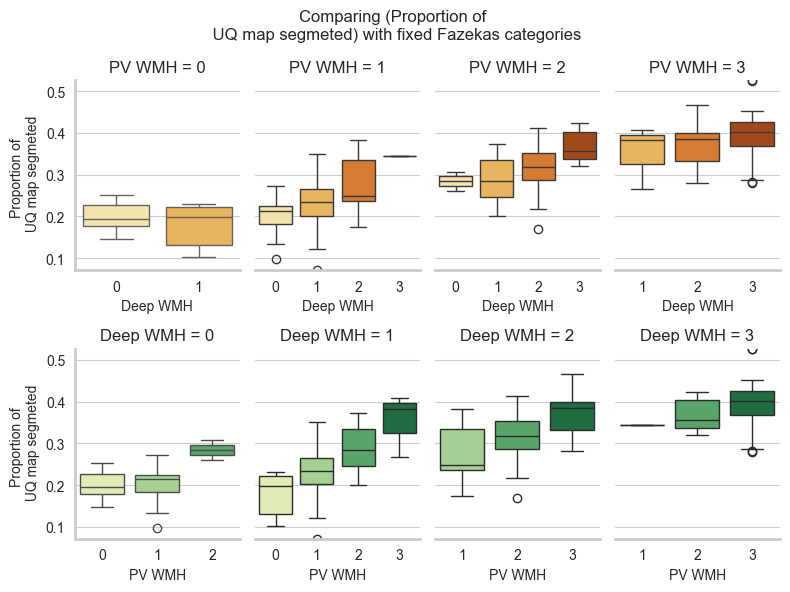

In [78]:
compare_d_vs_pv_fixed_plots(combined_df, y=f'ent0.3_prop_umap_segmented', ylabel="Proportion of \n UQ map segmeted", log_scatter_y=True)

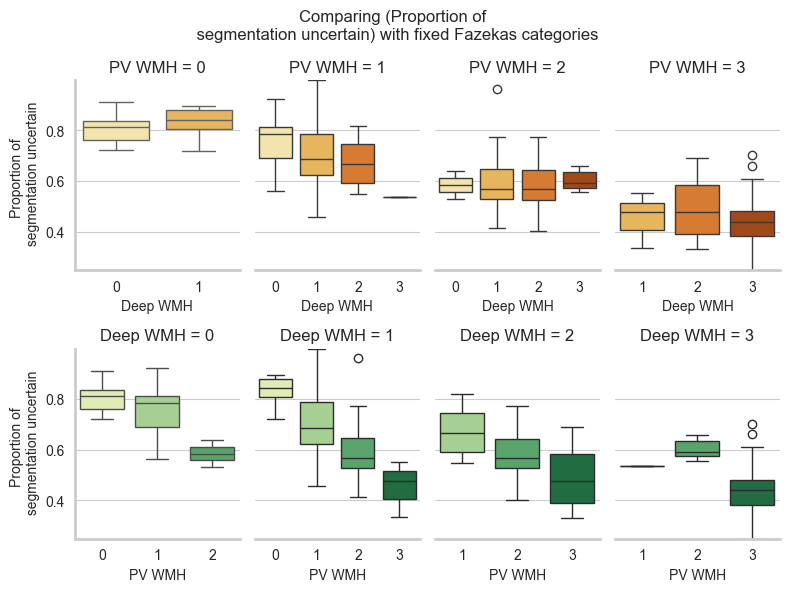

In [79]:
compare_d_vs_pv_fixed_plots(combined_df, y=f'ent0.3_prop_seg_uncertain', ylabel="Proportion of \n segmentation uncertain", log_scatter_y=True)

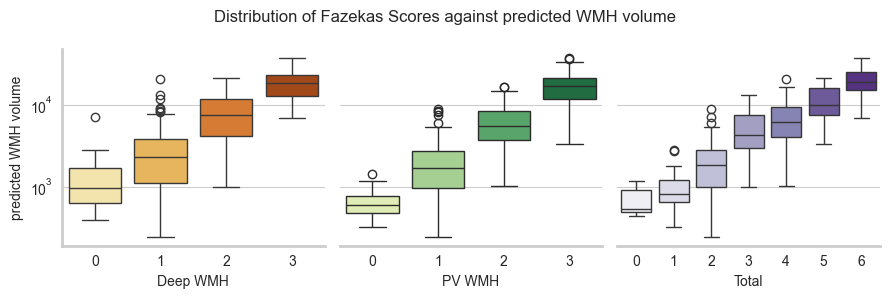

In [80]:
fig, axs = plt.subplots(1, 3, figsize=(9, 3))
simple_box_plot(axs[0], combined_df, x='DWMH', y='pred0.5_seg_volume', xlabel="Deep WMH", ylabel="predicted WMH volume", logy=True)
simple_box_plot(axs[1], combined_df, x='PVWMH', y='pred0.5_seg_volume', xlabel="PV WMH", ylabel="", logy=True, no_y_axis=True)
simple_box_plot(axs[2], combined_df, x='total_fazekas', y='pred0.5_seg_volume', xlabel='Total', ylabel="", logy=True, no_y_axis=True)
plt.suptitle("Distribution of Fazekas Scores against predicted WMH volume")
plt.savefig(save_folder+"predicted volme vs fazekas.pdf", bbox_inches="tight")
fig.tight_layout()